In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
EPL_PATH    = ('../raw_data/EPL/')
EFL_PATH    = ('../raw_data/EFL/')
OUT_PATH    = ('../data/')

We first need to turn the match-wise season data for all 14-19 seasons into a more comprehensible format. Each of the match-wise season dataframes will be aggregated into season totals.

In [4]:
def calculate_pts(x):
    """ calculate_pts
        Input:  
            <pandas series> x : row entry of raw season dataframe
        Output: 
            <pandas series> x : modified row entry
    """
    x['home_pts'] = 3 if x['FTR'] == 'H' else 1 if x['FTR'] == 'D' else 0
    x['away_pts'] = 3 if x['FTR'] == 'A' else 1 if x['FTR'] == 'D' else 0
    
    return x

def calculate_lead_pts(x, df_next):
    ''' calculate_lead_pts
        Input:
            <pandas series> x       : row entry of current year's season dataframe
            <pandas df>     df_next : dataframe of next season 
        Output:
            <pandas series> x : modified row entry containing leading pts of next season
    '''
    if df_next is not None:
        x['lead_pts'] = df_next[df_next.HomeTeam == x.team].home_pts.sum() + \
                        df_next[df_next.AwayTeam == x.team].away_pts.sum()
    else:
        x['lead_pts'] = np.nan
        
    return x
    
def aggregate_stats(x, season, season_next):
    """ aggregate_stats
        Input:  
            <pandas series> x       : row entry of season summary dataframe
            <pandas df> season      : dataframe containing total season data
            <pandas df> season_next : dataframe of next season
        Output: 
            <pandas series> x : modified row entry
    """
    df_home = season[season.HomeTeam == x.team]
    df_away = season[season.AwayTeam == x.team]
    
    x = calculate_lead_pts(x, season_next)
    
    x['season_pts']   = df_home.home_pts.sum() + df_away.away_pts.sum()
    x['goals_pg']     = (df_home.FTHG.sum() + df_away.FTAG.sum())/38
    x['goal_diff']    = df_home.FTHG.sum() + df_away.FTAG.sum() - df_home.FTAG.sum() - df_away.FTHG.sum()
    x['shots']        = df_home.HS.sum() + df_away.AS.sum()
    x['on_target']    = df_home.HST.sum() + df_away.AST.sum()
    x['free_kicks']   = df_home.HF.sum() + df_away.AF.sum()
    x['corner_kicks'] = df_home.HC.sum() + df_away.AC.sum()
    x['yellow_cards'] = df_home.HY.sum() + df_away.AY.sum()
    x['red_cards']    = df_home.HR.sum() + df_away.AR.sum()

    return x

In [5]:
def generate_season_stats(path, next_path):
    """ generate_season_stats
        Input:  
            <str>  path      : path to raw csv file containing season data of interest
            <str>  next_path : path to raw csv file containing next season data
        Output: 
            <pandas df> agg_df : dataframe contating season aggregate results
    """    
    # read season data
    season = pd.read_csv(path)
    # remove all betting odds features
    season = season[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
                     'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
                     'AC', 'HY', 'AY', 'HR', 'AR']]

    # calculate current season points
    season = season.apply(calculate_pts, axis=1)
    
    # add leading points if not the most recent year
    if next_path != None:
        season_next = pd.read_csv(next_path) 
        season_next = season_next.apply(calculate_pts, axis=1)
    else:
        season_next = None
        
    # generate season aggregate data
    agg_df = pd.DataFrame(season.HomeTeam.unique(), columns=['team'])
    agg_df = agg_df.apply(aggregate_stats, season=season, season_next=season_next, axis=1)
    agg_df = agg_df[pd.notnull(agg_df['team'])]
    
    # sort teams by standing
    agg_df = agg_df.sort_values(by=['season_pts', 'goal_diff'], ascending=[False, False])
    
    # add metadata for league and year
    agg_df.season = path.split('\\')[-1].split('.')[0]
    
    return agg_df

For predictions of each season, we will use the performance of the teams in the previous season (e.g. for predictions of the 15-16 season, the team performances of the 14-15 season will be used). Therefore, for each dataframe containing a single season, there will be a feature called lead_pts, which represents the number of points won in the next season.

In [6]:
# read all 14-19 EPL season data
all_epl = glob.glob('{}*.csv'.format(EPL_PATH))

# generate season aggregate dataframes for all 14-19 season data
epl_list = [generate_season_stats(season, all_epl[index+1]) \
            for (index, season) in enumerate(all_epl) if index < len(all_epl) - 1]
epl_list.append(generate_season_stats(all_epl[-1], None))

The following is what the dataframe looks like for the 14-15 season for the premier league:

In [9]:
epl_list[0]

,team,lead_pts,season_pts,goals_pg,goal_diff,shots,on_target,free_kicks,corner_kicks,yellow_cards,red_cards
19,Chelsea,83,91,1.894737,50,514,277,434,224,63,5
14,Man United,89,83,1.894737,38,555,286,486,221,60,2
13,Liverpool,68,82,1.500000,32,563,283,438,234,50,5
8,Arsenal,68,67,1.789474,37,462,274,479,211,55,2
16,Tottenham,60,65,1.394737,15,411,234,466,210,52,5
11,Blackburn,52,63,1.342105,9,384,183,568,230,76,6
15,Newcastle,43,58,1.236842,5,370,208,600,190,66,7
18,Bolton,56,56,1.289474,8,402,198,505,198,64,3
7,West Ham,41,55,1.368421,-3,354,173,497,206,50,2
9,Wigan,38,51,1.184211,-7,433,207,493,169,54,4


One challenge that we face is that the teams in the premier league are not identical from one season to the next (due to relagation/promotion three teams). This means that for teams that have just been promoted, we do not have data for how they performed in the premier league in the previous year. We will therefore take into consideration the performance of the promoted teams in the EFL Championship league in the previous year.

Each dataframe will contain the 17 teams that successfully remained in the premier league plus the three teams that will be promoted to the EPL the next season.

In [10]:
# read all 14-19 EFL season data
all_efl = glob.glob('{}*.csv'.format(EFL_PATH))

# generate season aggregate dataframes for all 14-19 season data
efl_list = [generate_season_stats(season, all_epl[index+1]) \
            for (index, season) in enumerate(all_efl) if index < len(all_efl) - 1]
efl_list.append(generate_season_stats(all_efl[-1], None))

# only keep promoted teams from efl dataframes
efl_list[:len(efl_list) - 1] = [df[df.lead_pts != 0] for (index, df) in enumerate(efl_list) \
                                if index < len(all_efl) - 1]
efl_list[-1] = efl_list[-1][efl_list[-1].team.isin(['Norwich', 'Sheffield United', 'Aston Villa'])]

The following is what the dataframe looks like for the promoted teams of the EFL Championship of the 14-15 season:

In [11]:
efl_list[0]

,team,lead_pts,season_pts,goals_pg,goal_diff,shots,on_target,free_kicks,corner_kicks,yellow_cards,red_cards
6,Reading,55,106,2.605263,67,495,271,504,287,38,0
7,Sheffield United,38,90,2.000000,30,505,257,571,290,63,2
10,Watford,28,81,2.026316,24,552,302,675,295,59,6


The problem with the approach is that we cannot directly compare the performance of the promoted teams from the EFL to the performance of the other teams in the EPL of the same year. To identify an approximation we can make, let us observe the performance of the bottom half of the league along with the newly promoted teams for the last five years.

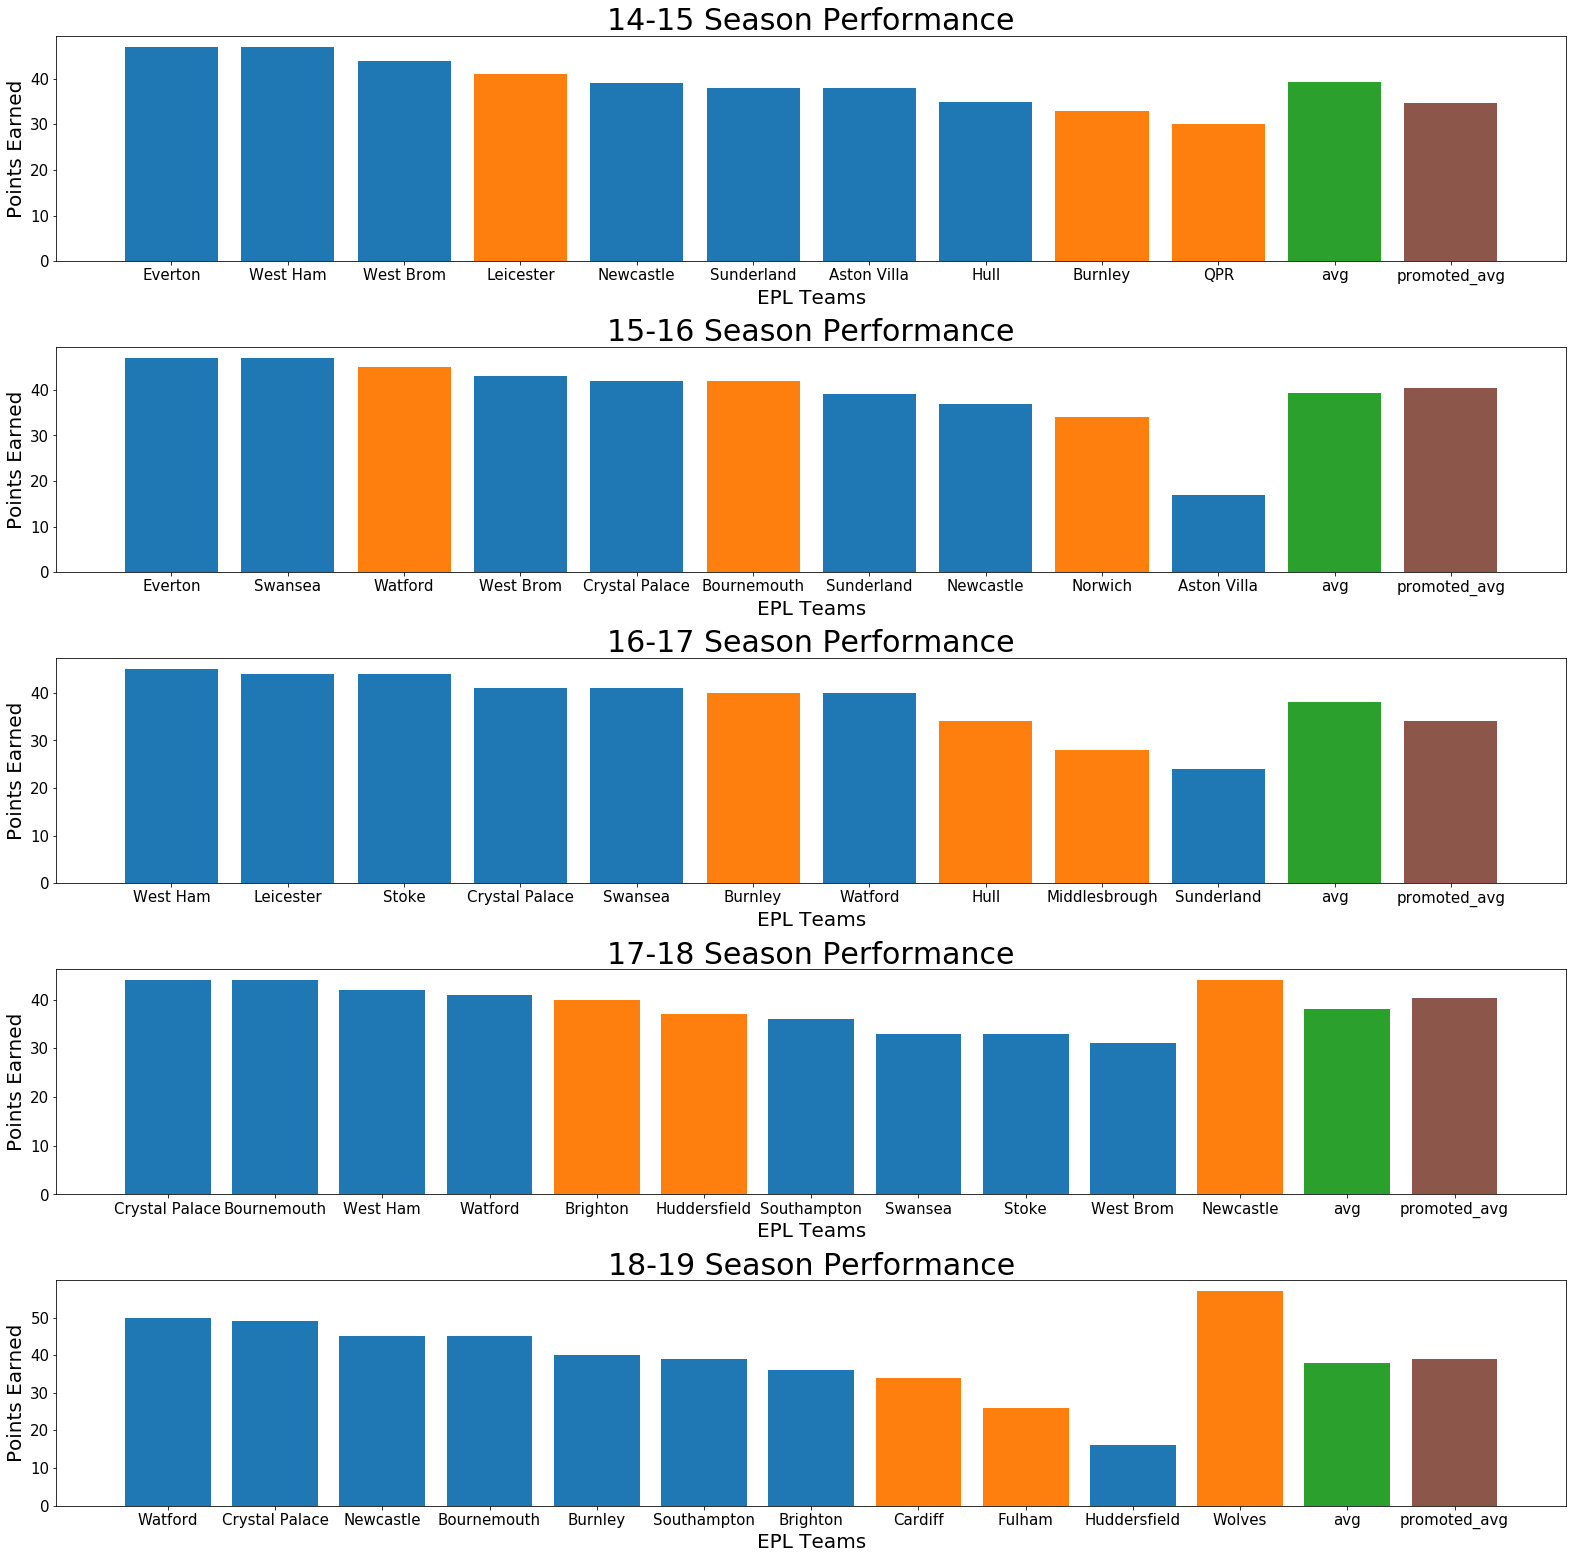

14-15 season offset between averages: 4.53
15-16 season offset between averages: -1.03
16-17 season offset between averages: 4.10
17-18 season offset between averages: -2.23
18-19 season offset between averages: -1.00


In [12]:
# bottom half of league by league standings
last_five = epl_list[9:]
bottom_half = [df[10:] for df in last_five]

# promoted teams of each season
promoted = [None]*len(last_five)
promoted[0] = last_five[0][last_five[0].team.isin(['Leicester', 'Burnley', 'QPR'])][['team', 'season_pts']]

# average of bottom half of league
average = [df[0:0][['team', 'season_pts']] for df in bottom_half]
average[0].loc[0] = ['avg', bottom_half[0][['season_pts']].mean()[0]]

# average of promoted teams
avg_promoted = [df[0:0][['team', 'season_pts']] for df in bottom_half]
avg_promoted[0].loc[0] = ['promoted_avg', promoted[0][['season_pts']].mean()[0]]

# compile list of promoted teams/averages
for i in range(1, len(last_five)):
    promoted[i] = last_five[i][last_five[i].team.isin(efl_list[i+8].team.unique())][['team', 'season_pts']]
    average[i].loc[0] = ['avg', bottom_half[i][['season_pts']].mean()[0]]
    avg_promoted[i].loc[0] = ['promoted_avg', promoted[i][['season_pts']].mean()[0]]
    
# generate bar graph subplots of points acquired in each season by bottom half + promoted teams
fig=plt.figure(figsize=(22,60))
columns = 1
rows = 14

for i in range(1, 6):
    # configure subplot
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title('{}-{} Season Performance'.format(13+i, 14+i), size=30)
    ax.set_xlabel('EPL Teams', size=20)
    ax.set_ylabel('Points Earned', size=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    # populate subplot
    plt.bar(bottom_half[i-1].team, bottom_half[i-1].season_pts)
    plt.bar(promoted[i-1].team, promoted[i-1].season_pts)
    plt.bar(average[i-1].team, average[i-1].season_pts)
    plt.bar(avg_promoted[i-1].team, avg_promoted[i-1].season_pts, color='tab:brown')
    
fig.tight_layout()
plt.show()

for i in range(len(promoted)):
    print('{:02d}-{:02d} season offset between averages: {:.2f}'\
          .format(14+i, 15+i, average[i].season_pts[0] - promoted[i].mean()[0]))

We can see from the bar graphs that for most newly promoted teams, their average performance is similar to the average performance of the bottom half of the league for every season (in fact, with the exception of the Wolves in the 18-19 season, all newly promoted teams ended up in the bottom half of the league each year). The offset between the two averages are no larger than 5 points every season.

Therefore, we will scale down the performance of the promoted teams for the EFL Championship to be less than or equal to the average performance of the bottom half of the league for each year.

In [14]:
# bottom half for all 05-19 seasons
bottom_half = [df[10:] for df in epl_list]

# generate average row for all seasons
for df in bottom_half:
    df.loc[-1] = df.mean()
    df['team'][-1] = 'avg'

# columns not for linearly scaling
cols = ['team', 'lead_pts', 'goal_diff']

# scale appropriate attributes of promoted teams' performance
for (index, df) in enumerate(efl_list):
    # scaling factor
    c = bottom_half[index].loc[-1]['season_pts']
    
    # apply scaling factor to EFL season stats
    df[df.columns.difference(cols)] = \
    df[df.columns.difference(cols)].apply(lambda row: row/row['season_pts']*c, axis=1)
    
    # assign average value for goal difference
    efl_list[index] = df.assign(**bottom_half[index][['goal_diff']][bottom_half[index].team == 'avg'] \
                                .to_dict(orient='records')[0])
    

D:\Program_Files\Anaconda\envs\proj1\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Program_Files\Anaconda\envs\proj1\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Program_Files\Anaconda\envs\proj1\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


The following is what the scaled down performance looks like for the promoted teams of the 14-15 season: 

Now we can add the promoted teams to the epl dataframes and write them to csv files.

Note: The relagated teams of each season are not required to predict the next year's season, but they have not yet been removed from the dataframe for analysis purposes in the future.

In [15]:
epl_list = [pd.concat([df, efl_list[index]], sort=False).round(2) for (index, df) in enumerate(epl_list)]

In [17]:
[df.to_csv('{}{:02d}-{:02d}_season_cleaned.csv'.format(OUT_PATH, 5+i, 6+i), index=False) \
 for (i, df) in enumerate(epl_list)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]